## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [1]:
%load_ext tensorboard

In [2]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
import matplotlib
import copy

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [5]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
tf.__version__

'1.15.2'

In [7]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test_orig) = mnist.load_data()

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
global_dataset_size = 6000
local_dataset_size = 40000

In [13]:
import utils

In [14]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [15]:
TRAIN_DATA_SIZE = 1000

In [16]:
x_train_a, y_train_a = utils.filter_data_by_labels(x_train, y_train, np.arange(2), TRAIN_DATA_SIZE)

In [17]:
x_train_b, y_train_b = utils.filter_data_by_labels(x_train, y_train, np.arange(2)+8, TRAIN_DATA_SIZE)

In [18]:
y_test_a, y_test_a = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(2))

In [19]:
y_test_b, y_test_b = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(2)+8)

In [20]:
# convert class vectors to binary class matrices
num_classes = 10
y_train_a = keras.utils.to_categorical(y_train_a, num_classes)
y_train_b = keras.utils.to_categorical(y_train_b, num_classes)
y_test_a = keras.utils.to_categorical(y_test_a, num_classes)
y_test_b = keras.utils.to_categorical(y_test_b, num_classes)

In [21]:
y_test = keras.utils.to_categorical(y_test_orig, num_classes)

### Define models and compile & fit function

In [22]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [23]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [24]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [25]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [61]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, verbose=1)

In [27]:
def add_hist_to_dict(d, hist):
    if 'loss' not in d:
        d['loss'] = hist[0]
    else:
        d['loss'] = np.append(d['loss'], hist[0])
    if 'acc' not in d:
        d['acc'] = hist[1]
    else:
        d['acc'] = np.append(d['acc'], hist[1])

In [28]:
tx, ty = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(5))

In [29]:
len(ty)

5139

In [30]:
tx, ty = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(5)+5)

In [31]:
len(ty)

4861

In [55]:
x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5, 20, 1, 1011)

In [56]:
y1

array([2, 9, 6, 4, 3, 3, 1, 0, 6, 7, 9, 9, 0, 4, 2, 3, 1, 5, 7, 5],
      dtype=uint8)

In [63]:
x04, y04 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5, 600, 1, 1000)
y_test_one_hot = keras.utils.to_categorical(y_test_orig, 10)
y04 = keras.utils.to_categorical(y04, 10)
test_model = custom_model()
compile_model(test_model)
for e in range(60):
    fit_model_with_datasets(test_model, 1, x04, y04)
    res = test_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0)
    print(res)

Training date and time : 
2020-09-07 16:53:55
Train on 600 samples
600/600 [==============================] - 1s 993us/sample - loss: 0.0905 - acc: 0.1050
[0.09012510870695115, 0.1105]
Training date and time : 
2020-09-07 16:54:01
Train on 600 samples
600/600 [==============================] - 0s 74us/sample - loss: 0.0901 - acc: 0.1150
[0.08976169431209564, 0.1171]
Training date and time : 
2020-09-07 16:54:02
Train on 600 samples
600/600 [==============================] - 0s 70us/sample - loss: 0.0897 - acc: 0.1167
[0.08942312107086181, 0.1279]
Training date and time : 
2020-09-07 16:54:03
Train on 600 samples
600/600 [==============================] - 0s 80us/sample - loss: 0.0893 - acc: 0.1317
[0.08909897447824477, 0.1415]
Training date and time : 
2020-09-07 16:54:03
Train on 600 samples
600/600 [==============================] - 0s 65us/sample - loss: 0.0889 - acc: 0.1483
[0.0887814815878868, 0.1565]
Training date and time : 
2020-09-07 16:54:04
Train on 600 samples
600/600 [====

600/600 [==============================] - 0s 55us/sample - loss: 0.0586 - acc: 0.6417
[0.06109259978532791, 0.6095]
Training date and time : 
2020-09-07 16:54:32
Train on 600 samples
600/600 [==============================] - 0s 61us/sample - loss: 0.0576 - acc: 0.6433
[0.0601152607858181, 0.6143]
Training date and time : 
2020-09-07 16:54:33
Train on 600 samples
600/600 [==============================] - 0s 59us/sample - loss: 0.0566 - acc: 0.6517
[0.05917518214583397, 0.6174]
Training date and time : 
2020-09-07 16:54:33
Train on 600 samples
600/600 [==============================] - 0s 52us/sample - loss: 0.0556 - acc: 0.6633
[0.058237419962882994, 0.622]
Training date and time : 
2020-09-07 16:54:34
Train on 600 samples
600/600 [==============================] - 0s 54us/sample - loss: 0.0546 - acc: 0.6600
[0.05730512084960938, 0.6276]
Training date and time : 
2020-09-07 16:54:35
Train on 600 samples
600/600 [==============================] - 0s 66us/sample - loss: 0.0536 - acc: 0

In [64]:
def get_losses_for_non_iid_spectrum(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    
    for r in np.arange(1, 0-diff, -diff):
        # get data
        randseed = (int)(r * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, r, randseed)
        x2, y2 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5, size, r, randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, epochs, x1, y1)
        fit_model_with_datasets(model2, epochs, x2, y2)
        
        #aggregate
        weights = [model1.get_weights(), model2.get_weights()]
        agg_weights = list()
        theta = 0.5
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        
    return res

In [92]:
def multiple_experiments(func, num, params):
    shape = (len(np.arange(1, 0-params['diff'], -params['diff'])), 2)
    res_sum = {}
    for n in range(num):
        print("------------- {}th experiment -------------".format(n))
        res = func(**params)
        
        for k in res: # for(models)
            if k not in res_sum:
                res_sum[k] = copy.deepcopy(res[k])
            else:
                for l in res_sum[k]: # for(test sets)
                    for i in res_sum[k][l]: # for(metric)
                        res_sum[k][l][i] += res[k][l][i]
                    
    for k in res_sum:
        for l in res_sum[k]:
            for i in res_sum[k][l]:
                res_sum[k][l][i] /= num
    
    return res_sum

In [66]:
init_model = custom_model()

In [67]:
params = {'model': init_model,
          'epochs': 20,
          'x_train': x_train,
          'y_train': y_train,
          'x_test': x_test,
          'y_test': y_test_orig,
          'size': 600,
          'diff': 0.1}

In [93]:
def get_mock_res(diff):
    mock_res = {}
    mock_res['model_aggr'] = {}
    mock_res['model_0to4'] = {}
    mock_res['model_5to9'] = {}
    mock_res['model_aggr']['test_all'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_0to4']['test_all'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_5to9']['test_all'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_aggr']['test_0to4'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_0to4']['test_0to4'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_5to9']['test_0to4'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_aggr']['test_5to9'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_0to4']['test_5to9'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    mock_res['model_5to9']['test_5to9'] = {'loss': np.array([1,1]), 'acc': np.array([3,3])}
    
    return mock_res

In [94]:
mock_res = multiple_experiments(get_mock_res, 10, {'diff': 0.1})

------------- 0th experiment -------------
------------- 1th experiment -------------
------------- 2th experiment -------------
------------- 3th experiment -------------
------------- 4th experiment -------------
------------- 5th experiment -------------
------------- 6th experiment -------------
------------- 7th experiment -------------
------------- 8th experiment -------------
------------- 9th experiment -------------


In [95]:
mock_res

{'model_aggr': {'test_all': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_0to4': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_5to9': {'loss': array([1., 1.]), 'acc': array([3., 3.])}},
 'model_0to4': {'test_all': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_0to4': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_5to9': {'loss': array([1., 1.]), 'acc': array([3., 3.])}},
 'model_5to9': {'test_all': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_0to4': {'loss': array([1., 1.]), 'acc': array([3., 3.])},
  'test_5to9': {'loss': array([1., 1.]), 'acc': array([3., 3.])}}}

In [96]:
res = get_losses_for_non_iid_spectrum(**params)

Training date and time : 
2020-09-07 18:01:28
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0905 - acc: 0.1200
Epoch 2/20
600/600 [==============================] - 0s 115us/sample - loss: 0.0899 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 109us/sample - loss: 0.0894 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 95us/sample - loss: 0.0890 - acc: 0.1467
Epoch 5/20
600/600 [==============================] - 0s 110us/sample - loss: 0.0885 - acc: 0.1567
Epoch 6/20
600/600 [==============================] - 0s 105us/sample - loss: 0.0881 - acc: 0.1850
Epoch 7/20
600/600 [==============================] - 0s 94us/sample - loss: 0.0877 - acc: 0.2133
Epoch 8/20
600/600 [==============================] - 0s 102us/sample - loss: 0.0872 - acc: 0.2333
Epoch 9/20
600/600 [==============================] - 0s 89us/sample - loss: 0.0868 - acc: 0.2533
Epoch 10/20
600/600 [==========================

Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0899 - acc: 0.1383
Epoch 2/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0893 - acc: 0.1483
Epoch 3/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0886 - acc: 0.1717
Epoch 4/20
600/600 [==============================] - 0s 84us/sample - loss: 0.0880 - acc: 0.1750
Epoch 5/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0874 - acc: 0.1983
Epoch 6/20
600/600 [==============================] - 0s 83us/sample - loss: 0.0867 - acc: 0.2367
Epoch 7/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0860 - acc: 0.2767
Epoch 8/20
600/600 [==============================] - 0s 86us/sample - loss: 0.0853 - acc: 0.3267
Epoch 9/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0845 - acc: 0.3683
Epoch 10/20
600/600 [==============================] - 0s 89us/sample - loss: 0.0836 - acc: 0.4033
Epoch 11/20
600/600 

600/600 [==============================] - 1s 2ms/sample - loss: 0.0887 - acc: 0.1633
Epoch 2/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0880 - acc: 0.1733
Epoch 3/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0874 - acc: 0.1833
Epoch 4/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0867 - acc: 0.2083
Epoch 5/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0860 - acc: 0.2317
Epoch 6/20
600/600 [==============================] - 0s 75us/sample - loss: 0.0853 - acc: 0.2567
Epoch 7/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0845 - acc: 0.2867
Epoch 8/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0837 - acc: 0.3167
Epoch 9/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0829 - acc: 0.3467
Epoch 10/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0819 - acc: 0.3783
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0881 - acc: 0.1883
Epoch 2/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0870 - acc: 0.2167
Epoch 3/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0860 - acc: 0.2417
Epoch 4/20
600/600 [==============================] - 0s 86us/sample - loss: 0.0848 - acc: 0.2767
Epoch 5/20
600/600 [==============================] - 0s 86us/sample - loss: 0.0836 - acc: 0.3017
Epoch 6/20
600/600 [==============================] - 0s 95us/sample - loss: 0.0823 - acc: 0.3400
Epoch 7/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0809 - acc: 0.3950
Epoch 8/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0794 - acc: 0.4733
Epoch 9/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0777 - acc: 0.5300
Epoch 10/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0759 - acc: 0.5767
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0876 - acc: 0.1983
Epoch 2/20
600/600 [==============================] - 0s 94us/sample - loss: 0.0863 - acc: 0.2150
Epoch 3/20
600/600 [==============================] - 0s 110us/sample - loss: 0.0850 - acc: 0.2383
Epoch 4/20
600/600 [==============================] - 0s 107us/sample - loss: 0.0836 - acc: 0.2817
Epoch 5/20
600/600 [==============================] - 0s 101us/sample - loss: 0.0820 - acc: 0.3400
Epoch 6/20
600/600 [==============================] - 0s 92us/sample - loss: 0.0803 - acc: 0.4100
Epoch 7/20
600/600 [==============================] - 0s 83us/sample - loss: 0.0783 - acc: 0.4900
Epoch 8/20
600/600 [==============================] - 0s 88us/sample - loss: 0.0762 - acc: 0.5667
Epoch 9/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0738 - acc: 0.6233
Epoch 10/20
600/600 [==============================] - 0s 94us/sample - loss: 0.0712 - acc: 0.6867
Epoch 11/20
600/600 [=======

600/600 [==============================] - 1s 2ms/sample - loss: 0.0868 - acc: 0.2267
Epoch 2/20
600/600 [==============================] - 0s 91us/sample - loss: 0.0849 - acc: 0.2500
Epoch 3/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0828 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0804 - acc: 0.3267
Epoch 5/20
600/600 [==============================] - 0s 89us/sample - loss: 0.0775 - acc: 0.4317
Epoch 6/20
600/600 [==============================] - 0s 83us/sample - loss: 0.0742 - acc: 0.5417
Epoch 7/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0706 - acc: 0.5650
Epoch 8/20
600/600 [==============================] - 0s 92us/sample - loss: 0.0671 - acc: 0.5933
Epoch 9/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0636 - acc: 0.6400
Epoch 10/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0602 - acc: 0.6817
Epoch 11/20
600/600 [==========

In [68]:
res = multiple_experiments(get_losses_for_non_iid_spectrum, 5, params)

------------- 0th experiment -------------
Training date and time : 
2020-09-07 17:04:49
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 970us/sample - loss: 0.0905 - acc: 0.1200
Epoch 2/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0899 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0894 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0890 - acc: 0.1467
Epoch 5/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0885 - acc: 0.1567
Epoch 6/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0881 - acc: 0.1850
Epoch 7/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0877 - acc: 0.2133
Epoch 8/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0872 - acc: 0.2333
Epoch 9/20
600/600 [==============================] - 0s 55us/sample - loss: 0.0868 - acc: 0.2533
Epoch 1

Training date and time : 
2020-09-07 17:05:44
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 979us/sample - loss: 0.0899 - acc: 0.1383
Epoch 2/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0893 - acc: 0.1483
Epoch 3/20
600/600 [==============================] - 0s 52us/sample - loss: 0.0886 - acc: 0.1717
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0880 - acc: 0.1750
Epoch 5/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0874 - acc: 0.1983
Epoch 6/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0867 - acc: 0.2367
Epoch 7/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0860 - acc: 0.2767
Epoch 8/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0853 - acc: 0.3267
Epoch 9/20
600/600 [==============================] - 0s 54us/sample - loss: 0.0845 - acc: 0.3683
Epoch 10/20
600/600 [=============================

Epoch 1/20
600/600 [==============================] - 1s 990us/sample - loss: 0.0887 - acc: 0.1633
Epoch 2/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0880 - acc: 0.1733
Epoch 3/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0874 - acc: 0.1833
Epoch 4/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0867 - acc: 0.2083
Epoch 5/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0860 - acc: 0.2317
Epoch 6/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0853 - acc: 0.2567
Epoch 7/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0845 - acc: 0.2867
Epoch 8/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0837 - acc: 0.3167
Epoch 9/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0829 - acc: 0.3467
Epoch 10/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0819 - acc: 0.3783
Epoch 11/20
600/60

600/600 [==============================] - 1s 1ms/sample - loss: 0.0881 - acc: 0.1883
Epoch 2/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0870 - acc: 0.2167
Epoch 3/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0860 - acc: 0.2417
Epoch 4/20
600/600 [==============================] - 0s 52us/sample - loss: 0.0848 - acc: 0.2767
Epoch 5/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0836 - acc: 0.3017
Epoch 6/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0823 - acc: 0.3400
Epoch 7/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0809 - acc: 0.3950
Epoch 8/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0794 - acc: 0.4733
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0777 - acc: 0.5300
Epoch 10/20
600/600 [==============================] - 0s 53us/sample - loss: 0.0759 - acc: 0.5767
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0876 - acc: 0.1983
Epoch 2/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0863 - acc: 0.2150
Epoch 3/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0850 - acc: 0.2383
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0836 - acc: 0.2817
Epoch 5/20
600/600 [==============================] - 0s 52us/sample - loss: 0.0820 - acc: 0.3400
Epoch 6/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0803 - acc: 0.4100
Epoch 7/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0783 - acc: 0.4900
Epoch 8/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0762 - acc: 0.5667
Epoch 9/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0738 - acc: 0.6233
Epoch 10/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0712 - acc: 0.6867
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0868 - acc: 0.2267
Epoch 2/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0849 - acc: 0.2500
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0828 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0804 - acc: 0.3267
Epoch 5/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0775 - acc: 0.4317
Epoch 6/20
600/600 [==============================] - 0s 53us/sample - loss: 0.0742 - acc: 0.5417
Epoch 7/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0706 - acc: 0.5650
Epoch 8/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0671 - acc: 0.5933
Epoch 9/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0636 - acc: 0.6400
Epoch 10/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0602 - acc: 0.6817
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0903 - acc: 0.1217
Epoch 2/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0896 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0889 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0883 - acc: 0.1667
Epoch 5/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0877 - acc: 0.2000
Epoch 6/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0871 - acc: 0.2383
Epoch 7/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0865 - acc: 0.2800
Epoch 8/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0858 - acc: 0.3100
Epoch 9/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0851 - acc: 0.3383
Epoch 10/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0844 - acc: 0.3700
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0904 - acc: 0.1117
Epoch 2/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0895 - acc: 0.1150
Epoch 3/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0888 - acc: 0.1467
Epoch 4/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0881 - acc: 0.1600
Epoch 5/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0873 - acc: 0.1917
Epoch 6/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0865 - acc: 0.2400
Epoch 7/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0857 - acc: 0.2950
Epoch 8/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0848 - acc: 0.3583
Epoch 9/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0839 - acc: 0.4117
Epoch 10/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0829 - acc: 0.4583
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0892 - acc: 0.1867
Epoch 2/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0882 - acc: 0.1967
Epoch 3/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0873 - acc: 0.2067
Epoch 4/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0862 - acc: 0.2300
Epoch 5/20
600/600 [==============================] - 0s 53us/sample - loss: 0.0850 - acc: 0.2767
Epoch 6/20
600/600 [==============================] - 0s 55us/sample - loss: 0.0836 - acc: 0.3617
Epoch 7/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0821 - acc: 0.4133
Epoch 8/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0804 - acc: 0.4483
Epoch 9/20
600/600 [==============================] - 0s 50us/sample - loss: 0.0787 - acc: 0.4483
Epoch 10/20
600/600 [==============================] - 0s 53us/sample - loss: 0.0770 - acc: 0.4567
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0875 - acc: 0.2200
Epoch 2/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0863 - acc: 0.2467
Epoch 3/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0851 - acc: 0.2817
Epoch 4/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0837 - acc: 0.3133
Epoch 5/20
600/600 [==============================] - 0s 53us/sample - loss: 0.0823 - acc: 0.3533
Epoch 6/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0806 - acc: 0.3933
Epoch 7/20
600/600 [==============================] - 0s 47us/sample - loss: 0.0788 - acc: 0.4500
Epoch 8/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0768 - acc: 0.5150
Epoch 9/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0746 - acc: 0.5450
Epoch 10/20
600/600 [==============================] - 0s 44us/sample - loss: 0.0722 - acc: 0.5750
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0874 - acc: 0.2233
Epoch 2/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0859 - acc: 0.2633
Epoch 3/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0843 - acc: 0.2983
Epoch 4/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0826 - acc: 0.3317
Epoch 5/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0807 - acc: 0.3700
Epoch 6/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0786 - acc: 0.4417
Epoch 7/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0762 - acc: 0.5133
Epoch 8/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0734 - acc: 0.5800
Epoch 9/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0705 - acc: 0.6417
Epoch 10/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0673 - acc: 0.6800
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0905 - acc: 0.1200
Epoch 2/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0899 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0894 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0890 - acc: 0.1467
Epoch 5/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0885 - acc: 0.1567
Epoch 6/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0881 - acc: 0.1850
Epoch 7/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0877 - acc: 0.2133
Epoch 8/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0872 - acc: 0.2333
Epoch 9/20
600/600 [==============================] - 0s 54us/sample - loss: 0.0868 - acc: 0.2533
Epoch 10/20
600/600 [==============================] - 0s 54us/sample - loss: 0.0863 - acc: 0.2817
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0899 - acc: 0.1383
Epoch 2/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0893 - acc: 0.1483
Epoch 3/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0886 - acc: 0.1717
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0880 - acc: 0.1750
Epoch 5/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0874 - acc: 0.1983
Epoch 6/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0867 - acc: 0.2367
Epoch 7/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0860 - acc: 0.2767
Epoch 8/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0853 - acc: 0.3267
Epoch 9/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0845 - acc: 0.3683
Epoch 10/20
600/600 [==============================] - 0s 55us/sample - loss: 0.0836 - acc: 0.4033
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0887 - acc: 0.1633
Epoch 2/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0880 - acc: 0.1733
Epoch 3/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0874 - acc: 0.1833
Epoch 4/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0867 - acc: 0.2083
Epoch 5/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0860 - acc: 0.2317
Epoch 6/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0853 - acc: 0.2567
Epoch 7/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0845 - acc: 0.2867
Epoch 8/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0837 - acc: 0.3167
Epoch 9/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0829 - acc: 0.3467
Epoch 10/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0819 - acc: 0.3783
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0881 - acc: 0.1883
Epoch 2/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0870 - acc: 0.2167
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0860 - acc: 0.2417
Epoch 4/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0848 - acc: 0.2767
Epoch 5/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0836 - acc: 0.3017
Epoch 6/20
600/600 [==============================] - 0s 52us/sample - loss: 0.0823 - acc: 0.3400
Epoch 7/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0809 - acc: 0.3950
Epoch 8/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0794 - acc: 0.4733
Epoch 9/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0777 - acc: 0.5300
Epoch 10/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0759 - acc: 0.5767
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0876 - acc: 0.1983
Epoch 2/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0863 - acc: 0.2150
Epoch 3/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0850 - acc: 0.2383
Epoch 4/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0836 - acc: 0.2817
Epoch 5/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0820 - acc: 0.3400
Epoch 6/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0803 - acc: 0.4100
Epoch 7/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0783 - acc: 0.4900
Epoch 8/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0762 - acc: 0.5667
Epoch 9/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0738 - acc: 0.6233
Epoch 10/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0712 - acc: 0.6867
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0868 - acc: 0.2267
Epoch 2/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0849 - acc: 0.2500
Epoch 3/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0828 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0804 - acc: 0.3267
Epoch 5/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0775 - acc: 0.4317
Epoch 6/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0742 - acc: 0.5417
Epoch 7/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0706 - acc: 0.5650
Epoch 8/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0671 - acc: 0.5933
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0636 - acc: 0.6400
Epoch 10/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0602 - acc: 0.6817
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0903 - acc: 0.1217
Epoch 2/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0896 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0889 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0883 - acc: 0.1667
Epoch 5/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0877 - acc: 0.2000
Epoch 6/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0871 - acc: 0.2383
Epoch 7/20
600/600 [==============================] - 0s 55us/sample - loss: 0.0865 - acc: 0.2800
Epoch 8/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0858 - acc: 0.3100
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0851 - acc: 0.3383
Epoch 10/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0844 - acc: 0.3700
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0904 - acc: 0.1117
Epoch 2/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0895 - acc: 0.1150
Epoch 3/20
600/600 [==============================] - 0s 76us/sample - loss: 0.0888 - acc: 0.1467
Epoch 4/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0881 - acc: 0.1600
Epoch 5/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0873 - acc: 0.1917
Epoch 6/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0865 - acc: 0.2400
Epoch 7/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0857 - acc: 0.2950
Epoch 8/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0848 - acc: 0.3583
Epoch 9/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0839 - acc: 0.4117
Epoch 10/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0829 - acc: 0.4583
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0892 - acc: 0.1867
Epoch 2/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0882 - acc: 0.1967
Epoch 3/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0873 - acc: 0.2067
Epoch 4/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0862 - acc: 0.2300
Epoch 5/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0850 - acc: 0.2767
Epoch 6/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0836 - acc: 0.3617
Epoch 7/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0821 - acc: 0.4133
Epoch 8/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0804 - acc: 0.4483
Epoch 9/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0787 - acc: 0.4483
Epoch 10/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0770 - acc: 0.4567
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0875 - acc: 0.2200
Epoch 2/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0863 - acc: 0.2467
Epoch 3/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0851 - acc: 0.2817
Epoch 4/20
600/600 [==============================] - 0s 88us/sample - loss: 0.0837 - acc: 0.3133
Epoch 5/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0823 - acc: 0.3533
Epoch 6/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0806 - acc: 0.3933
Epoch 7/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0788 - acc: 0.4500
Epoch 8/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0768 - acc: 0.5150
Epoch 9/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0746 - acc: 0.5450
Epoch 10/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0722 - acc: 0.5750
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 1ms/sample - loss: 0.0874 - acc: 0.2233
Epoch 2/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0859 - acc: 0.2633
Epoch 3/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0843 - acc: 0.2983
Epoch 4/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0826 - acc: 0.3317
Epoch 5/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0807 - acc: 0.3700
Epoch 6/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0786 - acc: 0.4417
Epoch 7/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0762 - acc: 0.5133
Epoch 8/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0734 - acc: 0.5800
Epoch 9/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0705 - acc: 0.6417
Epoch 10/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0673 - acc: 0.6800
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0905 - acc: 0.1200
Epoch 2/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0899 - acc: 0.1333
Epoch 3/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0894 - acc: 0.1450
Epoch 4/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0890 - acc: 0.1467
Epoch 5/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0885 - acc: 0.1567
Epoch 6/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0881 - acc: 0.1850
Epoch 7/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0877 - acc: 0.2133
Epoch 8/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0872 - acc: 0.2333
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0868 - acc: 0.2533
Epoch 10/20
600/600 [==============================] - 0s 86us/sample - loss: 0.0863 - acc: 0.2817
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0899 - acc: 0.1383
Epoch 2/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0893 - acc: 0.1483
Epoch 3/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0886 - acc: 0.1717
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0880 - acc: 0.1750
Epoch 5/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0874 - acc: 0.1983
Epoch 6/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0867 - acc: 0.2367
Epoch 7/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0860 - acc: 0.2767
Epoch 8/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0853 - acc: 0.3267
Epoch 9/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0845 - acc: 0.3683
Epoch 10/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0836 - acc: 0.4033
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0887 - acc: 0.1633
Epoch 2/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0880 - acc: 0.1733
Epoch 3/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0874 - acc: 0.1833
Epoch 4/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0867 - acc: 0.2083
Epoch 5/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0860 - acc: 0.2317
Epoch 6/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0853 - acc: 0.2567
Epoch 7/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0845 - acc: 0.2867
Epoch 8/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0837 - acc: 0.3167
Epoch 9/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0829 - acc: 0.3467
Epoch 10/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0819 - acc: 0.3783
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0881 - acc: 0.1883
Epoch 2/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0870 - acc: 0.2167
Epoch 3/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0860 - acc: 0.2417
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0848 - acc: 0.2767
Epoch 5/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0836 - acc: 0.3017
Epoch 6/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0823 - acc: 0.3400
Epoch 7/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0809 - acc: 0.3950
Epoch 8/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0794 - acc: 0.4733
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0777 - acc: 0.5300
Epoch 10/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0759 - acc: 0.5767
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0876 - acc: 0.1983
Epoch 2/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0863 - acc: 0.2150
Epoch 3/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0850 - acc: 0.2383
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0836 - acc: 0.2817
Epoch 5/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0820 - acc: 0.3400
Epoch 6/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0803 - acc: 0.4100
Epoch 7/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0783 - acc: 0.4900
Epoch 8/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0762 - acc: 0.5667
Epoch 9/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0738 - acc: 0.6233
Epoch 10/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0712 - acc: 0.6867
Epoch 11/20
600/600 [==========

600/600 [==============================] - 1s 2ms/sample - loss: 0.0868 - acc: 0.2267
Epoch 2/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0849 - acc: 0.2500
Epoch 3/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0828 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0804 - acc: 0.3267
Epoch 5/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0775 - acc: 0.4317
Epoch 6/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0742 - acc: 0.5417
Epoch 7/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0706 - acc: 0.5650
Epoch 8/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0671 - acc: 0.5933
Epoch 9/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0636 - acc: 0.6400
Epoch 10/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0602 - acc: 0.6817
Epoch 11/20
600/600 [==========

In [101]:
res['model_0to4']['test_0to4']['loss']

array([0.0774995 , 0.06750726, 0.0634514 , 0.06093475, 0.05733573,
       0.05263903, 0.04174873, 0.04208819, 0.03487321, 0.03192197,
       0.02948421])

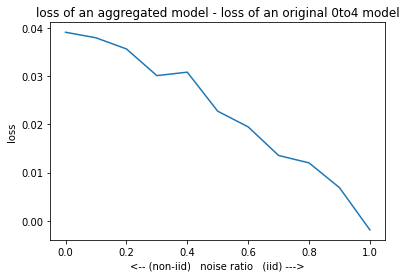

In [69]:
import matplotlib as plot
diff = list()
for orig, aggr in zip(res['model_0to4']['test_0to4']['loss'], res['model_aggr']['test_0to4']['loss']):
    diff.append(aggr - orig)
plt.plot(np.arange(1, 0-0.1, -0.1), np.array(diff))
plt.title("loss of an aggregated model - loss of an original 0to4 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

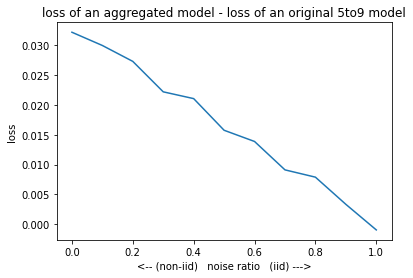

In [70]:
import matplotlib as plot
diff = list()
for orig, aggr in zip(res['model_5to9']['test_5to9']['loss'], res['model_aggr']['test_5to9']['loss']):
    diff.append(aggr - orig)
plt.plot(np.arange(1, 0-0.1, -0.1), np.array(diff))
plt.title("loss of an aggregated model - loss of an original 5to9 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

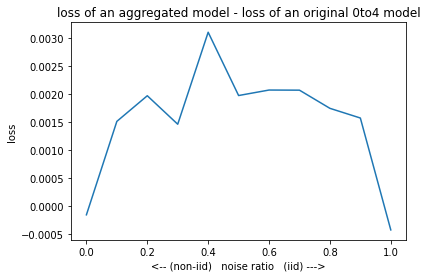

In [97]:
import matplotlib as plot
diff = list()
for orig, aggr in zip(res['model_0to4']['test_all']['loss'], res['model_aggr']['test_all']['loss']):
    diff.append(aggr - orig)
plt.plot(np.arange(1, 0-0.1, -0.1), np.array(diff))
plt.title("loss of an aggregated model - loss of an original 0to4 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

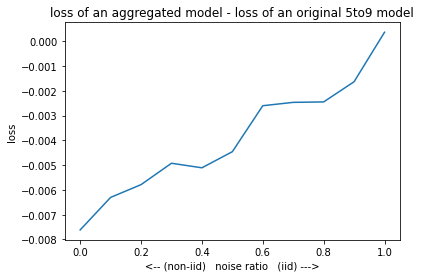

In [98]:
import matplotlib as plot
diff = list()
for orig, aggr in zip(res['model_5to9']['test_all']['loss'], res['model_aggr']['test_all']['loss']):
    diff.append(aggr - orig)
plt.plot(np.arange(1, 0-0.1, -0.1), np.array(diff))
plt.title("loss of an aggregated model - loss of an original 5to9 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

### Difference between the 0to4 model and 5to9 model

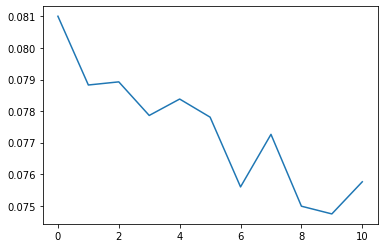

In [99]:
plt.plot(res['model_0to4']['test_all']['loss'])
plt.show()

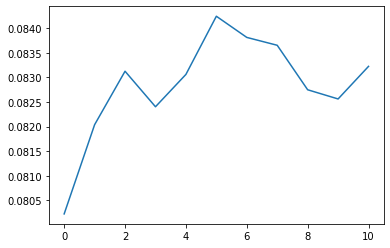

In [100]:
plt.plot(res['model_5to9']['test_all']['loss'])
plt.show()

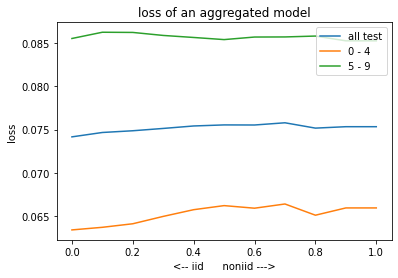

In [72]:
import matplotlib as plot
plt.plot(np.arange(1, 0-0.1, -0.1), np.array([l[0] for l in hist_list]))
plt.plot(np.arange(1, 0-0.1, -0.1), np.array([l[0] for l in hist0to4_list]))
plt.plot(np.arange(1, 0-0.1, -0.1), np.array([l[0] for l in hist5to9_list]))
plt.legend(["all test", "0 - 4", "5 - 9"])
plt.title("loss of an aggregated model - loss of an original 0to4 model")
plt.ylabel("loss")
plt.xlabel("<-- iid      noniid --->")
plt.show()

In [121]:
model1 = custom_model()
model2 = custom_model()
model1.set_weights(init_model.get_weights())
model2.set_weights(init_model.get_weights())
compile_model(model1)
compile_model(model2)

In [122]:
compile_model(init_model)

In [123]:
# test how the model converges according to the data size
hist = fit_model_with_datasets(init_model, 50, x_train_a, y_train_b)

Training date and time : 
2020-09-01 09:14:11
Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 150us/sample - loss: 0.0918 - acc: 0.0244 - val_loss: 0.0904 - val_acc: 0.0700
Epoch 2/50
900/900 [==============================] - 0s 44us/sample - loss: 0.0877 - acc: 0.2067 - val_loss: 0.0862 - val_acc: 0.2800
Epoch 3/50
900/900 [==============================] - 0s 44us/sample - loss: 0.0830 - acc: 0.4111 - val_loss: 0.0815 - val_acc: 0.3800
Epoch 4/50
900/900 [==============================] - 0s 44us/sample - loss: 0.0779 - acc: 0.4978 - val_loss: 0.0765 - val_acc: 0.4700
Epoch 5/50
900/900 [==============================] - 0s 40us/sample - loss: 0.0726 - acc: 0.5233 - val_loss: 0.0718 - val_acc: 0.4500
Epoch 6/50
900/900 [==============================] - 0s 43us/sample - loss: 0.0678 - acc: 0.5267 - val_loss: 0.0677 - val_acc: 0.4700
Epoch 7/50
900/900 [==============================] - 0s 40us/sample - loss: 0.0638 - acc: 0.5344

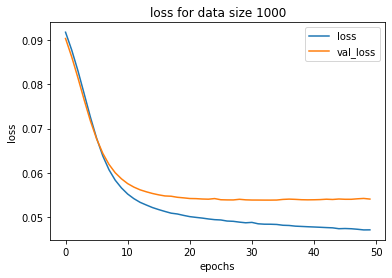

In [124]:
import matplotlib as plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(["loss", "val_loss"])
plt.title("loss for data size " + str(TRAIN_DATA_SIZE))
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [28]:
model1_list = list()
for _ in range(9):
    model1_list.append(tf.keras.models.clone_model(model1)) 
    model1_list[_].set_weights(model1.get_weights())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
for i in range(len(model1_list)):
    compile_model(model1_list[i])
    fit_model_with_datasets(model1_list[i], (i+1)*5, x_train_0_to_4, y_train_0_to_4)

Training date and time : 
2020-08-31 14:38:07
Train on 11398 samples, validate on 1267 samples
Epoch 1/5
11398/11398 [==============================] - 1s 56us/sample - loss: 0.0243 - acc: 0.8492 - val_loss: 0.0019 - val_acc: 0.9976
Epoch 2/5
11398/11398 [==============================] - 0s 34us/sample - loss: 0.0013 - acc: 0.9974 - val_loss: 7.2349e-04 - val_acc: 0.9992
Epoch 3/5
11398/11398 [==============================] - 0s 34us/sample - loss: 7.8100e-04 - acc: 0.9979 - val_loss: 4.4403e-04 - val_acc: 0.9992
Epoch 4/5
11398/11398 [==============================] - 0s 37us/sample - loss: 6.0157e-04 - acc: 0.9978 - val_loss: 3.3499e-04 - val_acc: 0.9992
Epoch 5/5
11398/11398 [==============================] - 0s 37us/sample - loss: 5.0733e-04 - acc: 0.9981 - val_loss: 2.6500e-04 - val_acc: 0.9992
Training date and time : 
2020-08-31 14:38:09
Train on 11398 samples, validate on 1267 samples
Epoch 1/10
11398/11398 [==============================] - 0s 43us/sample - loss: 0.0244 - ac

Epoch 4/25
11398/11398 [==============================] - 0s 35us/sample - loss: 6.0148e-04 - acc: 0.9980 - val_loss: 3.2990e-04 - val_acc: 0.9992
Epoch 5/25
11398/11398 [==============================] - 0s 30us/sample - loss: 5.0345e-04 - acc: 0.9981 - val_loss: 2.7718e-04 - val_acc: 0.9992
Epoch 6/25
11398/11398 [==============================] - 0s 34us/sample - loss: 4.4706e-04 - acc: 0.9982 - val_loss: 2.1182e-04 - val_acc: 0.9992
Epoch 7/25
11398/11398 [==============================] - 0s 34us/sample - loss: 4.0464e-04 - acc: 0.9982 - val_loss: 1.8118e-04 - val_acc: 0.9992
Epoch 8/25
11398/11398 [==============================] - 0s 33us/sample - loss: 3.7202e-04 - acc: 0.9983 - val_loss: 1.5216e-04 - val_acc: 1.0000
Epoch 9/25
11398/11398 [==============================] - 0s 34us/sample - loss: 3.4813e-04 - acc: 0.9984 - val_loss: 1.3533e-04 - val_acc: 1.0000
Epoch 10/25
11398/11398 [==============================] - 0s 29us/sample - loss: 3.2718e-04 - acc: 0.9985 - val_loss:

Epoch 23/40
11398/11398 [==============================] - 0s 34us/sample - loss: 1.9885e-04 - acc: 0.9990 - val_loss: 4.8737e-05 - val_acc: 1.0000
Epoch 24/40
11398/11398 [==============================] - 0s 37us/sample - loss: 1.9325e-04 - acc: 0.9990 - val_loss: 4.6999e-05 - val_acc: 1.0000
Epoch 25/40
11398/11398 [==============================] - 0s 36us/sample - loss: 1.8807e-04 - acc: 0.9991 - val_loss: 4.4588e-05 - val_acc: 1.0000
Epoch 26/40
11398/11398 [==============================] - 0s 35us/sample - loss: 1.8346e-04 - acc: 0.9992 - val_loss: 4.2402e-05 - val_acc: 1.0000
Epoch 27/40
11398/11398 [==============================] - 0s 33us/sample - loss: 1.7885e-04 - acc: 0.9992 - val_loss: 4.0222e-05 - val_acc: 1.0000
Epoch 28/40
11398/11398 [==============================] - 0s 32us/sample - loss: 1.7417e-04 - acc: 0.9993 - val_loss: 3.8217e-05 - val_acc: 1.0000
Epoch 29/40
11398/11398 [==============================] - 0s 36us/sample - loss: 1.7058e-04 - acc: 0.9993 - val

Epoch 38/45
11398/11398 [==============================] - 0s 29us/sample - loss: 1.4324e-04 - acc: 0.9994 - val_loss: 2.7025e-05 - val_acc: 1.0000
Epoch 39/45
11398/11398 [==============================] - 0s 35us/sample - loss: 1.4272e-04 - acc: 0.9995 - val_loss: 2.6090e-05 - val_acc: 1.0000
Epoch 40/45
11398/11398 [==============================] - 0s 34us/sample - loss: 1.4009e-04 - acc: 0.9995 - val_loss: 2.5283e-05 - val_acc: 1.0000
Epoch 41/45
11398/11398 [==============================] - 0s 35us/sample - loss: 1.3808e-04 - acc: 0.9995 - val_loss: 2.4493e-05 - val_acc: 1.0000
Epoch 42/45
11398/11398 [==============================] - 0s 35us/sample - loss: 1.3606e-04 - acc: 0.9995 - val_loss: 2.3827e-05 - val_acc: 1.0000
Epoch 43/45
11398/11398 [==============================] - 0s 30us/sample - loss: 1.3423e-04 - acc: 0.9995 - val_loss: 2.3117e-05 - val_acc: 1.0000
Epoch 44/45
11398/11398 [==============================] - 0s 34us/sample - loss: 1.3261e-04 - acc: 0.9995 - val

In [30]:
fit_model_with_datasets(model2, 50, x_train_5_to_9, y_train_5_to_9)

Training date and time : 
2020-08-31 14:39:39
Train on 10620 samples, validate on 1180 samples
Epoch 1/50
10620/10620 [==============================] - 1s 48us/sample - loss: 0.0357 - acc: 0.8228 - val_loss: 0.0090 - val_acc: 0.9661
Epoch 2/50
10620/10620 [==============================] - 0s 33us/sample - loss: 0.0076 - acc: 0.9622 - val_loss: 0.0057 - val_acc: 0.9678
Epoch 3/50
10620/10620 [==============================] - 0s 32us/sample - loss: 0.0054 - acc: 0.9709 - val_loss: 0.0046 - val_acc: 0.9763
Epoch 4/50
10620/10620 [==============================] - 0s 35us/sample - loss: 0.0045 - acc: 0.9747 - val_loss: 0.0041 - val_acc: 0.9780
Epoch 5/50
10620/10620 [==============================] - 0s 35us/sample - loss: 0.0039 - acc: 0.9777 - val_loss: 0.0038 - val_acc: 0.9788
Epoch 6/50
10620/10620 [==============================] - 0s 36us/sample - loss: 0.0036 - acc: 0.9800 - val_loss: 0.0036 - val_acc: 0.9788
Epoch 7/50
10620/10620 [==============================] - 0s 36us/sampl

In [31]:
import semantic_drift
model_dists = [semantic_drift.l2_distance(init_model, m) for m in model1_list]

In [32]:
model_dists

[1.3300415,
 1.424989,
 1.4784721,
 1.5186309,
 1.5505308,
 1.5796684,
 1.6027185,
 1.6240375,
 1.643143]

### Aggregate models (all of model1s and only the final model2(e=50))

In [33]:
agg_weights_list_per_pi = list()
theta_list = [0, 0.5, 1]
for m1 in model1_list:
    weights = [m1.get_weights(), model2.get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    agg_weights_list_per_pi.append(agg_weights_list)

In [34]:
model2.evaluate(x=x_test, y=y_test, verbose=1)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.1497 - acc: 0.1958


[0.14974196043014526, 0.1958]

In [45]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
accs1 = list()
losses2 = list()
accs2 = list()
agg_accs = list()
acc_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
    
    acc_losses.append(score[0])
    agg_accs.append(score[1])
    losses1.append(comp_score1[0])
    accs1.append(comp_score1[1])
    losses2.append(comp_score2[0])
    accs2.append(comp_score2[1])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

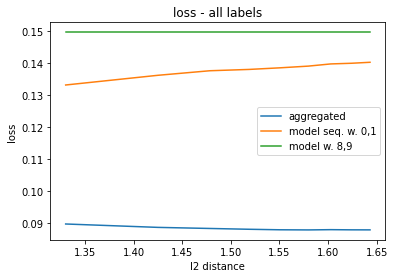

In [46]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated", "model seq. w. 0,1", "model w. 8,9"])
plt.title("loss - all labels")
plt.ylabel("loss")
plt.xlabel("l2 distance")
plt.show()

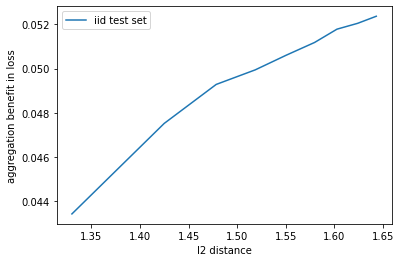

In [37]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(B))
plt.legend(["iid test set", "test w. 0,1", "test w. 8,9"])
plt.ylabel("aggregation benefit in loss")
plt.xlabel("l2 distance")
plt.show()

In [38]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
losses2 = list()
agg_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)
    
    agg_losses.append(score[0])
    losses1.append(comp_score1[0])
    losses2.append(comp_score2[0])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

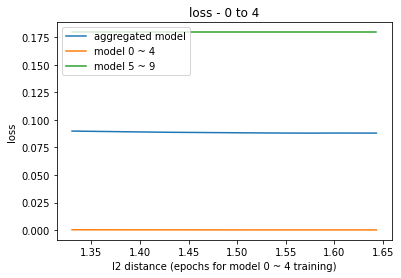

In [39]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated model", "model 0,1", "model 8,9"])
plt.title("loss - 0 to 4")
plt.ylabel("loss")
plt.xlabel("l2 distance (epochs for model 0,1 training)")
plt.show()

In [42]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
accs1 = list()
losses2 = list()
accs2 = list()
agg_accs = list()
acc_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)
    
    acc_losses.append(score[0])
    agg_accs.append(score[1])
    losses1.append(comp_score1[0])
    accs1.append(comp_score1[1])
    losses2.append(comp_score2[0])
    accs2.append(comp_score2[1])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

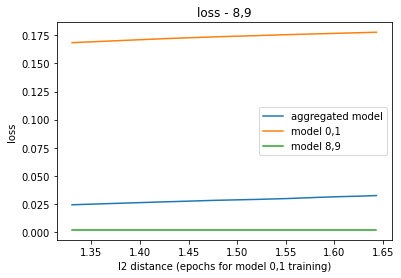

In [44]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated model", "model 0,1", "model 8,9"])
plt.title("loss - 8,9")
plt.ylabel("loss")
plt.xlabel("l2 distance (epochs for model 0,1 training)")
plt.show()